<a href="https://colab.research.google.com/github/Tej-55/SAiDL-Summer-Assignment-2023-CV/blob/main/Zero_shot_segmentation_using_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git #clip api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-46p323ad
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-46p323ad
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=345aeb4a8ee3d00685dee2ad008b2147488baa451a9d9979f38d803d8e84f554
  Stored in directory: /tmp/pip-ephem-wheel-cache-fkxz69_j/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
!nvidia-smi #check the GPU

Mon May 29 10:19:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import clip
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import time
import os
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.optim import AdamW

In [ ]:
!pip install transformers

from transformers import AutoProcessor, CLIPSegForImageSegmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.1 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics
from torchmetrics.functional.classification import binary_accuracy
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics import Dice

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.0 MB/s eta 0:00:00


In [ ]:
class DiceLoss(torch.nn.Module): #defining the Dice Loss
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  #dice coeff
        
        return 1 - dice

# Load Dataset

In [ ]:
#Getting the zip file

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1-w0_9TzFXdktLurhf0UnJ1FvA8fpxSGl'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])

In [ ]:
!unzip VGPhraseCut_V0_sub_train+val.zip

In [ ]:
df = pd.read_json("/content/VGPhraseCut_V0_sub_train+val/train/refer_train.json")

In [ ]:
df.head(20)

,phrase_structure,task_id,instance_boxes,image_id,ann_ids,phrase,Polygons
0,"{'attributes': [], 'type': 'name', 'name': 'wi...",2359296__3539024,"[[47.5, 0.833333333333333, 136.83333333333331,...",2359296,[3539024],windows,"[[[[53.333333333333336, 20.833333333333332], [..."
1,"{'attributes': ['brown'], 'type': 'name', 'nam...",2359296__1870150,"[[50.0, 101.66666666666667, 33.5, 45.999999999...",2359296,[1870150],brown lampshade,"[[[[68.33333333333333, 146.66666666666666], [7..."
2,"{'attributes': [], 'type': 'verbose', 'name': ...",2359296__2313724,"[[5.0, 121.66666666666667, 489.33333333333337,...",2359296,[2313724],line on ground,"[[[[5.833333333333334, 289.1666666666667], [15..."
3,"{'attributes': ['brown'], 'type': 'verbose', '...",2359296__2405205,"[[0.0, 129.16666666666669, 500.16666666666663,...",2359296,[2405205],brown floor,"[[[[2.5, 205.83333333333334], [0.0, 294.166666..."
4,"{'attributes': [], 'type': 'verbose', 'name': ...",2359296__1953769_1912261,"[[130.0, 136.66666666666666, 210.1666666666666...",2359296,"[1953769, 1912261]",bed,"[[[[131.66666666666666, 159.16666666666669], [..."
5,"{'attributes': [], 'type': 'name', 'name': 'st...",4263__4366569,"[[48.0, 341.33333333333337, 742.3333333333334,...",4263,[4366569],stones,"[[[[48.0, 502.66666666666663], [108.0, 493.333..."
6,"{'attributes': [], 'type': 'name', 'name': 'mo...",4263__4366573,"[[5.333333333333334, 0.0, 790.3333333333333, 2...",4263,[4366573],mountain,"[[[[5.333333333333334, 177.33333333333334], [8..."
7,"{'attributes': [], 'type': 'verbose', 'name': ...",4263__4558766,"[[665.3333333333334, 184.0, 74.33333333333326,...",4263,[4558766],man,"[[[[678.6666666666667, 378.6666666666667], [67..."
8,"{'attributes': [], 'type': 'name', 'name': 'la...",4263__4366525,"[[316.0, 161.33333333333331, 157.0, 163.666666...",4263,[4366525],lady sitting in chair,"[[[[316.0, 317.3333333333333], [316.0, 317.333..."
9,"{'attributes': [], 'type': 'verbose', 'name': ...",4263__4366578,"[[329.33333333333337, 242.66666666666669, 87.6...",4263,[4366578],pants,"[[[[329.33333333333337, 302.6666666666667], [3..."


In [ ]:
#Store the images in a dictionary

folder_path = "/content/VGPhraseCut_V0_sub_train+val/train/images"

# Get a list of all the files in the folder
file_list = os.listdir(folder_path)

# empty list to hold the image data
image_data_dict = dict()

for file_name in file_list:
    # Check if the file is an image
    if file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".jpeg"):
        # Read the image file
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path).resize((352,352)).convert("RGB")
        # Append the image data to the dict
        image_data_dict[int(file_name[:-4])] = image


In [ ]:
df['image'] = df['image_id'].apply(image_data_dict.get)
df.dropna(inplace=True)
df.reset_index(drop = True, inplace = True)

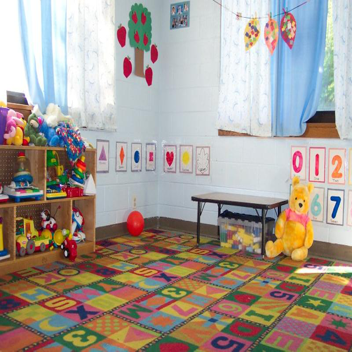

In [ ]:
img = df['image'][0] #checking the image
img

In [ ]:
def polygons_to_mask(polygons, w, h): #polygon function to get masks
    p_mask = np.zeros((h, w))
    polygons = polygons[0]
    for polygon in polygons:
        if len(polygon) < 2:
            continue
        p = []
        for x, y in polygon:
            p.append((int(x), int(y)))
        img = Image.new('L', (w, h), 0)
        ImageDraw.Draw(img).polygon(p, outline=1, fill=1)
        mask = np.array(img)
        p_mask += mask
    p_mask = p_mask > 0
    return p_mask

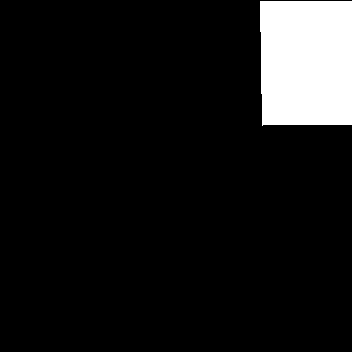

In [ ]:
#visualising the mask

w, h = img.size
mask = polygons_to_mask(df['Polygons'][0], w, h)
Image.fromarray(mask)

In [ ]:
df

,phrase_structure,task_id,instance_boxes,image_id,ann_ids,phrase,Polygons,image
0,"{'attributes': [], 'type': 'name', 'name': 'pi...",4276__4367141,"[[260.0, 1.333333333333333, 105.0, 125.0000000...",4276,[4367141],pictures are in wall,"[[[[260.0, 1.333333333333333], [354.6666666666...",<PIL.Image.Image image mode=RGB size=352x352 a...
1,"{'attributes': ['white'], 'type': 'attribute',...",4276__4367131,"[[493.33333333333337, 1.333333333333333, 132.9...",4276,[4367131],white curtain,"[[[[625.3333333333333, 206.66666666666669], [4...",<PIL.Image.Image image mode=RGB size=352x352 a...
2,"{'attributes': [], 'type': 'name', 'name': 'ru...",4276__4564267,"[[0.0, 344.0, 799.6666666666666, 195.666666666...",4276,[4564267],rug,"[[[[0.0, 420.0], [217.33333333333334, 385.3333...",<PIL.Image.Image image mode=RGB size=352x352 a...
3,"{'attributes': ['wooden'], 'type': 'name', 'na...",4276__4367181,"[[8.0, 213.33333333333334, 219.66666666666666,...",4276,[4367181],wooden shelf,"[[[[8.0, 213.33333333333334], [218.66666666666...",<PIL.Image.Image image mode=RGB size=352x352 a...
4,"{'attributes': [], 'type': 'verbose', 'name': ...",4276__4367138_4367177,"[[5.333333333333334, 156.0, 211.66666666666666...",4276,"[4367138, 4367177]",toys,"[[[[14.666666666666666, 168.0], [45.3333333333...",<PIL.Image.Image image mode=RGB size=352x352 a...
...,...,...,...,...,...,...,...,...
30743,"{'attributes': ['baseball'], 'type': 'name', '...",2356409__2109160,"[[186.66666666666669, 101.66666666666667, 102....",2356409,[2109160],baseball jersey,"[[[[187.5, 142.5], [187.5, 140.0], [186.666666...",<PIL.Image.Image image mode=RGB size=352x352 a...
30744,"{'attributes': ['grounded'], 'type': 'name', '...",2356409__2172806,"[[255.0, 263.3333333333333, 154.33333333333331...",2356409,[2172806],grounded shadow,"[[[[255.0, 291.6666666666667], [274.1666666666...",<PIL.Image.Image image mode=RGB size=352x352 a...
30745,"{'attributes': [], 'type': 'name', 'name': 'ma...",2356409__2634290,"[[170.83333333333334, 70.83333333333333, 119.3...",2356409,[2634290],man wearing pants,"[[[[172.5, 109.16666666666666], [177.5, 125.0]...",<PIL.Image.Image image mode=RGB size=352x352 a...
30746,"{'attributes': ['neatly trimmed'], 'type': 'na...",2356409__2409698,"[[411.6666666666667, 72.5, 85.99999999999994, ...",2356409,[2409698],neatly trimmed grass,"[[[[495.0, 198.33333333333334], [495.0, 198.33...",<PIL.Image.Image image mode=RGB size=352x352 a...


In [ ]:
train, test = train_test_split(df, random_state=42,train_size=0.75) #train_test_split
train.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [ ]:
processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

In [ ]:
class PhrasecutDataset(torch.utils.data.Dataset):
    def __init__(self, phrases, images, labels):
        self.phrases = phrases
        self.images = images
        self.labels = labels

    def __getitem__(self, idx):
        item = processor(text=(self.phrases[idx]), images=(self.images[idx]), padding="max_length", return_tensors="pt")
        
        item['label'] = torch.tensor(polygons_to_mask(self.labels[idx], self.images[idx].size[0], self.images[idx].size[1]), dtype=	torch.float32)

        return item

    def __len__(self):
        return len(self.labels)


train_data = PhrasecutDataset(train['phrase'], train['image'], train['Polygons'])
test_data = PhrasecutDataset(test['phrase'], test['image'], test['Polygons'])

# Clip transformer-based decoder

In [ ]:

model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

## Binary Crossentropy Loss

In [ ]:


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
#loss = torch.nn.BCELoss()
loss_fn = torch.nn.BCEWithLogitsLoss()

iou = BinaryJaccardIndex().to(device)
dice = Dice(num_class=2, average='micro').to(device)

optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
for epoch in range(3):
    print(f'EPOCH {epoch+1}:')
    for i, batch in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        pixel_values = batch['pixel_values'].squeeze(1).to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        loss = loss_fn(outputs[0], labels)
        loss.backward()
        optim.step()

        if i%100 == 99 or i == len(train_loader)-1:
          train_accuracy = binary_accuracy(outputs[0], labels).to(device)
          train_dice = dice(outputs[0], labels.type(torch.int32))
          train_iou = iou(outputs[0], labels)
          print(f'    batch: {i+1} loss: {loss.item()} train mertics: {(train_accuracy, train_iou, train_dice)}\n')



model.eval()

EPOCH 1:
    batch: 100 loss: 0.21798208355903625 train mertics: (tensor(0.9019, device='cuda:0'), tensor(0.1571, device='cuda:0'), tensor(0.1349, device='cuda:0'))

    batch: 200 loss: 0.24676820635795593 train mertics: (tensor(0.8903, device='cuda:0'), tensor(0.2011, device='cuda:0'), tensor(0.2191, device='cuda:0'))

    batch: 300 loss: 0.24587665498256683 train mertics: (tensor(0.8994, device='cuda:0'), tensor(0.4282, device='cuda:0'), tensor(0.5211, device='cuda:0'))

    batch: 400 loss: 0.2069244682788849 train mertics: (tensor(0.9172, device='cuda:0'), tensor(0.3339, device='cuda:0'), tensor(0.4276, device='cuda:0'))

    batch: 500 loss: 0.2826719582080841 train mertics: (tensor(0.8964, device='cuda:0'), tensor(0.2486, device='cuda:0'), tensor(0.3106, device='cuda:0'))

    batch: 600 loss: 0.2562093138694763 train mertics: (tensor(0.8843, device='cuda:0'), tensor(0.3613, device='cuda:0'), tensor(0.3895, device='cuda:0'))

    batch: 700 loss: 0.2513178288936615 train mertic

CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

## Dice loss

In [ ]:
model_2 = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_2.to(device)
model_2.train()

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

loss_fn = DiceLoss()

iou = BinaryJaccardIndex().to(device)
dice = Dice(num_class=2, average='micro').to(device)

optim = AdamW(model_2.parameters(), lr=5e-5)

In [ ]:
for epoch in range(3):
    print(f'EPOCH {epoch+1}:')
    for i, batch in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        pixel_values = batch['pixel_values'].squeeze(1).to(device)
        labels = batch['label'].to(device)
        outputs = model_2(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        loss = loss_fn(outputs[0], labels)
        loss.backward()
        optim.step()

        if i%100 == 99 or i == len(train_loader)-1:
          train_accuracy = binary_accuracy(outputs[0], labels).to(device)
          train_dice = dice(outputs[0], labels.type(torch.int32))
          train_iou = iou(outputs[0], labels)
          print(f'    batch: {i+1} loss: {loss.item()} train mertics: {(train_accuracy, train_iou, train_dice)}\n')



model_2.eval()

EPOCH 1:
    batch: 100 loss: 0.4819920063018799 train mertics: (tensor(0.8156, device='cuda:0'), tensor(0.3683, device='cuda:0'), tensor(0.5314, device='cuda:0'))

    batch: 200 loss: 0.5015159845352173 train mertics: (tensor(0.8121, device='cuda:0'), tensor(0.3374, device='cuda:0'), tensor(0.5060, device='cuda:0'))

    batch: 300 loss: 0.4438142776489258 train mertics: (tensor(0.8453, device='cuda:0'), tensor(0.3865, device='cuda:0'), tensor(0.5619, device='cuda:0'))

    batch: 400 loss: 0.4658131003379822 train mertics: (tensor(0.8604, device='cuda:0'), tensor(0.3688, device='cuda:0'), tensor(0.5396, device='cuda:0'))

    batch: 500 loss: 0.3374205231666565 train mertics: (tensor(0.8757, device='cuda:0'), tensor(0.4995, device='cuda:0'), tensor(0.6647, device='cuda:0'))

    batch: 600 loss: 0.4108688235282898 train mertics: (tensor(0.8662, device='cuda:0'), tensor(0.4218, device='cuda:0'), tensor(0.5990, device='cuda:0'))

    batch: 700 loss: 0.3236633539199829 train mertics: 

CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

# U-net inspired convolutional decoder

In [ ]:
class custom_model(nn.Module):
    def __init__(self):
        super(custom_model, self).__init__()
        
        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.encoder_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.encoder_conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.encoder_conv4 = nn.Conv2d(256, 512, 3, padding=1)
        
        # Decoder
        self.decoder_conv1 = nn.Conv2d(512+77, 256, 3, padding=1)
        self.decoder_conv2 = nn.Conv2d(256+77, 128, 3, padding=1)
        self.decoder_conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.decoder_conv4 = nn.Conv2d(64+3, 1, 1)
        
        # Max Pool
        self.max_pool = nn.MaxPool2d(2, 2)
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Activation function
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x1, x2, x3):
        # Encoder
        x = self.relu(self.encoder_conv1(x1)) # (64, 352, 352)
        x = self.max_pool(x) # (64, 176, 176)
        
        x = self.relu(self.encoder_conv2(x)) # (128, 176, 176)
        x = self.max_pool(x) # (128, 88, 88)
        
        x = self.relu(self.encoder_conv3(x)) # (256, 88, 88)
        x = self.max_pool(x) # (256, 44, 44)
        
        x = self.relu(self.encoder_conv4(x)) # (512, 44, 44)
        x = self.max_pool(x) # (512, 22, 22)
        
        # Decoder
        x = self.upsample(x) # (512, 44, 44)
        x = torch.cat([x, x3.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 44, 44)], dim=1) # (512+77, 44, 44)
        x = self.relu(self.decoder_conv1(x)) # (256, 44, 44)
        
        x = self.upsample(x) # (256, 88, 88)
        x = torch.cat([x, x2.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 88, 88)], dim=1) # (256+77, 88, 88)
        x = self.relu(self.decoder_conv2(x)) # (128, 88, 88)
        
        x = self.upsample(x) # (128, 176, 176)
        x = self.relu(self.decoder_conv3(x)) # (64, 176, 176) 
    
        #x = self.decoder_conv4(x) # (1, 176, 176)
        #x = self.upsample(x) # (1, 352, 352)
        x = self.upsample(x) # (64, 352, 352)
        x = torch.cat([x, x1], dim=1) # (64+3, 352, 352)
        x = self.decoder_conv4(x) # (1, 352, 352)
        
        # Output
        x = torch.sigmoid(x) # (1, 352, 352)
        
        return x


## Binary Crossentropy Loss

In [ ]:
model_3 = custom_model()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_3.to(device)
model_3.train()

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

loss_fn = torch.nn.BCEWithLogitsLoss()

iou = BinaryJaccardIndex().to(device)
dice = Dice(num_class=2, average='micro').to(device)

optim = AdamW(model_3.parameters(), lr=5e-5)

In [ ]:
for epoch in range(3):
    print(f'EPOCH {epoch+1}:')
    for i, batch in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        pixel_values = batch['pixel_values'].squeeze(1).to(device)
        labels = batch['label'].to(device)

        #print(f'x1: {pixel_values.shape}, x2: {input_ids.shape}, x3: {attention_mask.shape}')


        outputs = model_3(x1=pixel_values, x2=input_ids, x3=attention_mask).squeeze(1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()

        if i%100 == 99 or i == len(train_loader)-1:
          train_accuracy = binary_accuracy(outputs, labels).to(device)
          train_dice = dice(outputs, labels.type(torch.int32))
          train_iou = iou(outputs, labels)
          print(f'    batch: {i+1} loss: {loss.item()} train mertics: {(train_accuracy, train_iou, train_dice)}\n')



model_3.eval()

EPOCH 1:
    batch: 100 loss: 0.6931473612785339 train mertics: (tensor(0.8349, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 200 loss: 0.6931473612785339 train mertics: (tensor(0.8581, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 300 loss: 0.6931473612785339 train mertics: (tensor(0.8252, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 400 loss: 0.6931473612785339 train mertics: (tensor(0.8565, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 500 loss: 0.6931473612785339 train mertics: (tensor(0.8767, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 600 loss: 0.6931473612785339 train mertics: (tensor(0.8688, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 700 loss: 0.6931473612785339 train mertics: (tensor(0.8274, device='cuda:0'), tensor(0., dev

custom_model(
  (encoder_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv1): Conv2d(589, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv2): Conv2d(333, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv4): Conv2d(67, 1, kernel_size=(1, 1), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (relu): ReLU(inplace=True)
)

## Dice Loss

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


model_4 = custom_model()
model_4.to(device)
model_4.train()

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

loss_fn = DiceLoss()

iou = BinaryJaccardIndex().to(device)
dice = Dice(num_class=2, average='micro').to(device)

optim = AdamW(model_4.parameters(), lr=5e-5)

In [ ]:
for epoch in range(3):
    print(f'EPOCH {epoch+1}:')
    for i, batch in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        pixel_values = batch['pixel_values'].squeeze(1).to(device)
        labels = batch['label'].to(device)

        #print(f'x1: {pixel_values.shape}, x2: {input_ids.shape}, x3: {attention_mask.shape}')


        outputs = model_4(x1=pixel_values, x2=input_ids, x3=attention_mask).squeeze(1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()

        if i%100 == 99 or i == len(train_loader)-1:
          train_accuracy = binary_accuracy(outputs, labels).to(device)
          train_dice = dice(outputs, labels.type(torch.int32))
          train_iou = iou(outputs, labels)
          print(f'    batch: {i+1} loss: {loss.item()} train mertics: {(train_accuracy, train_iou, train_dice)}\n')



model_4.eval()

EPOCH 1:
    batch: 100 loss: 0.7396913170814514 train mertics: (tensor(0.1584, device='cuda:0'), tensor(0.1583, device='cuda:0'), tensor(0.2734, device='cuda:0'))

    batch: 200 loss: 0.7611430287361145 train mertics: (tensor(0.8431, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 300 loss: 0.7730131149291992 train mertics: (tensor(0.8532, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 400 loss: 0.7700285911560059 train mertics: (tensor(0.8507, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 500 loss: 0.8145148754119873 train mertics: (tensor(0.8861, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 600 loss: 0.7209056615829468 train mertics: (tensor(0.8064, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))

    batch: 700 loss: 0.7701461315155029 train mertics: (tensor(0.8508, device='cuda:0'), tensor

custom_model(
  (encoder_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv1): Conv2d(589, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv2): Conv2d(333, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv4): Conv2d(67, 1, kernel_size=(1, 1), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (relu): ReLU(inplace=True)
)